# <center> Trabajo Semanal 4 <center>
### <center> Autor: Arturo Huber <center>

## Introduccción Teórica

En este trabajo abordaremos el tema de la estimación espectral de señales en presencia de ruido, con el objetivo de evaluar el desempeño de diferentes factores en la estimación de amplitud y frecuencia. La estimación de parámetros espectrales es un aspecto fundamental en áreas como comunicaciones digitales, procesamiento de audio o caracterización de sistemas, donde las mediciones suelen estar contaminadas por ruido.

Para ello consideraremos señales senoidales parametrizadas y afectadas por ruido blanco aditivo, generando 200 realizaciones con dos niveles de relación señal-ruido (3 dB y 10 dB). A cada señal se le aplicarán diferentes ventanas (Rectangular, Flattop, Blackman-Harris y Hamming), con el fin de analizar el efecto de la elección de ventana sobre los resultados, ya que características como el ancho del lóbulo principal y los lóbulos laterales pueden influir significativamente en el sesgo y la varianza de los estimadores.

Las señales parametrizadas tendrán la siguiente forma:

$$
x(k)=a_0⋅sen(Ω_1⋅n)+n_a(n)
$$

Siendo:

$a_0 = 2$ <br>
$Ω_1= Ω_0+fr⋅2\pi N$ <br>
$Ω_0=\frac{\pi}{2}$ <br>
$f_r \sim \mathcal{U}(-2,2)$ <br>
$n_a \sim \mathcal{N}(0,\sigma^2)$

Luego, para estimar la amplitud y frecuencia, vamos a usar los siguientes estimadores:

De amplitud $a_1$ :

$$
\hat{a}_1^{(i)} = \left| X_w^{(i)}(\Omega_0) \right| = \left| \mathcal{F}\{ x(n)\cdot w_i(n) \} \right|
$$

Y de frecuencia $\Omega_1$:

$$
\hat{\Omega}_1^{(i)} = \arg \max_{\Omega} \left\{ \, \left| X_w^{(i)}(\Omega) \right| \, \right\}
$$

Finalmente, los resultados se compararán a partir de medidas estadísticas (bias y varianza) para cada combinación de ventana y nivel de SNR, con el fin de establecer qué factores tienen mayor impacto en la precisión de los estimadores.

## Analisis y Desarrollo

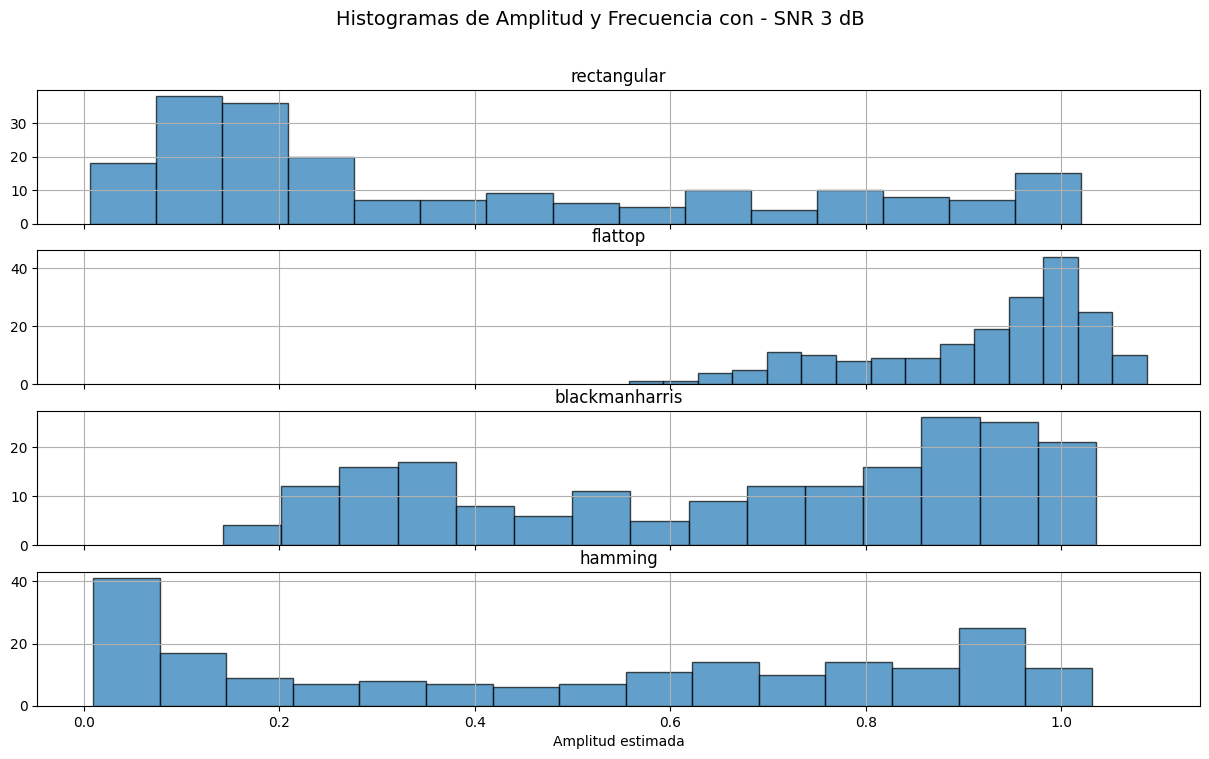

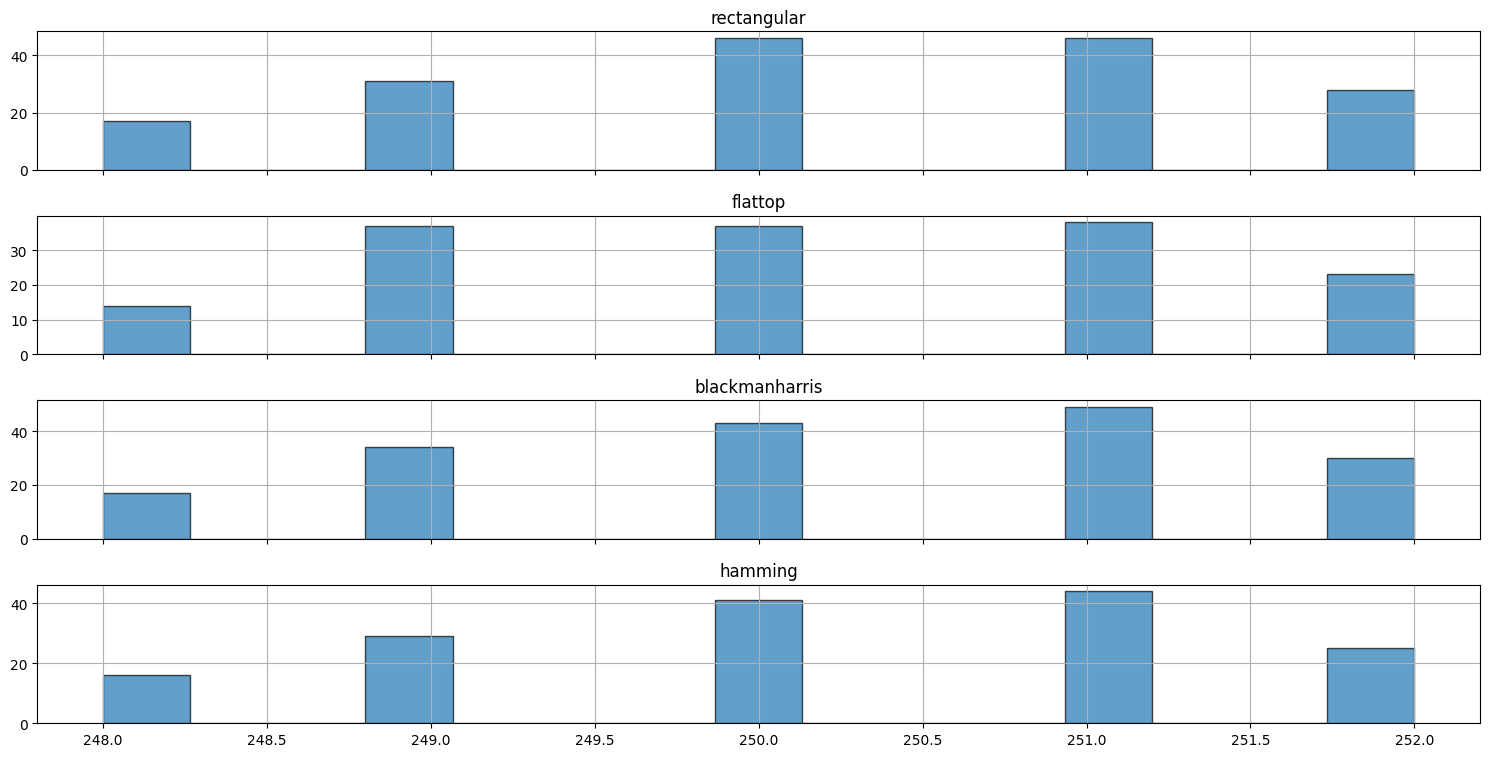

<Figure size 640x480 with 0 Axes>

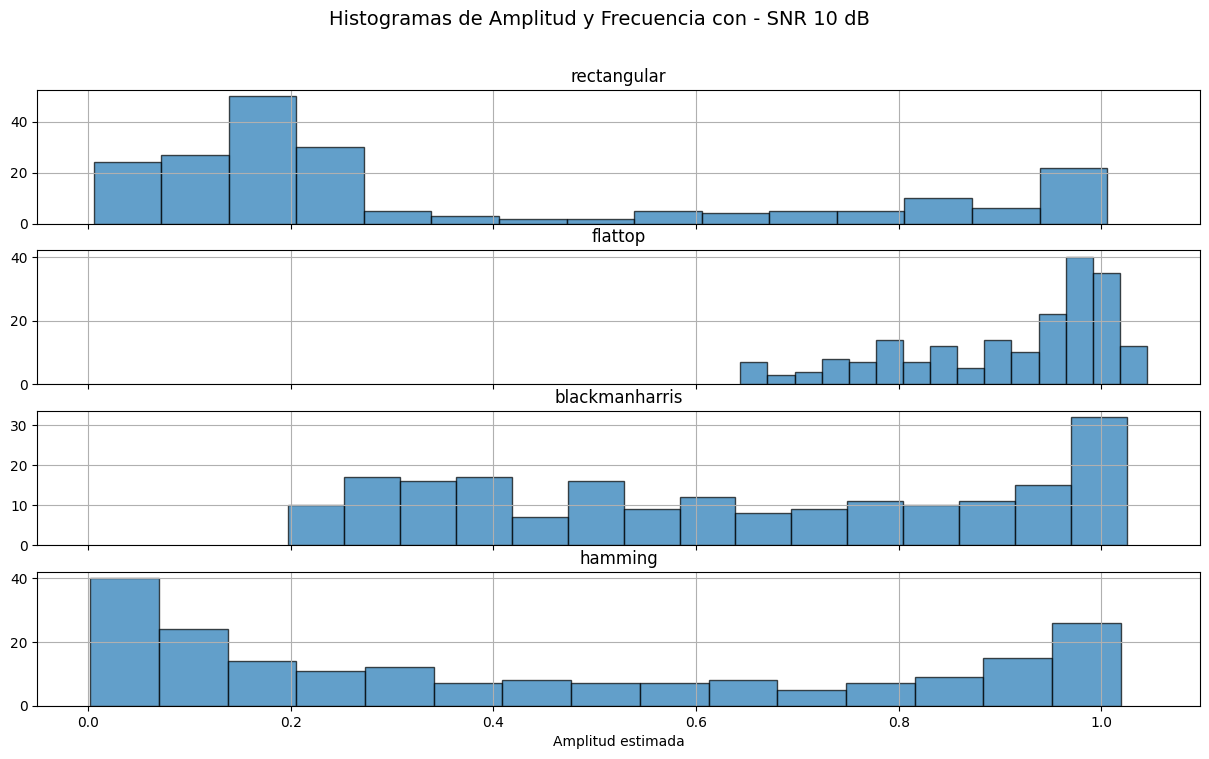

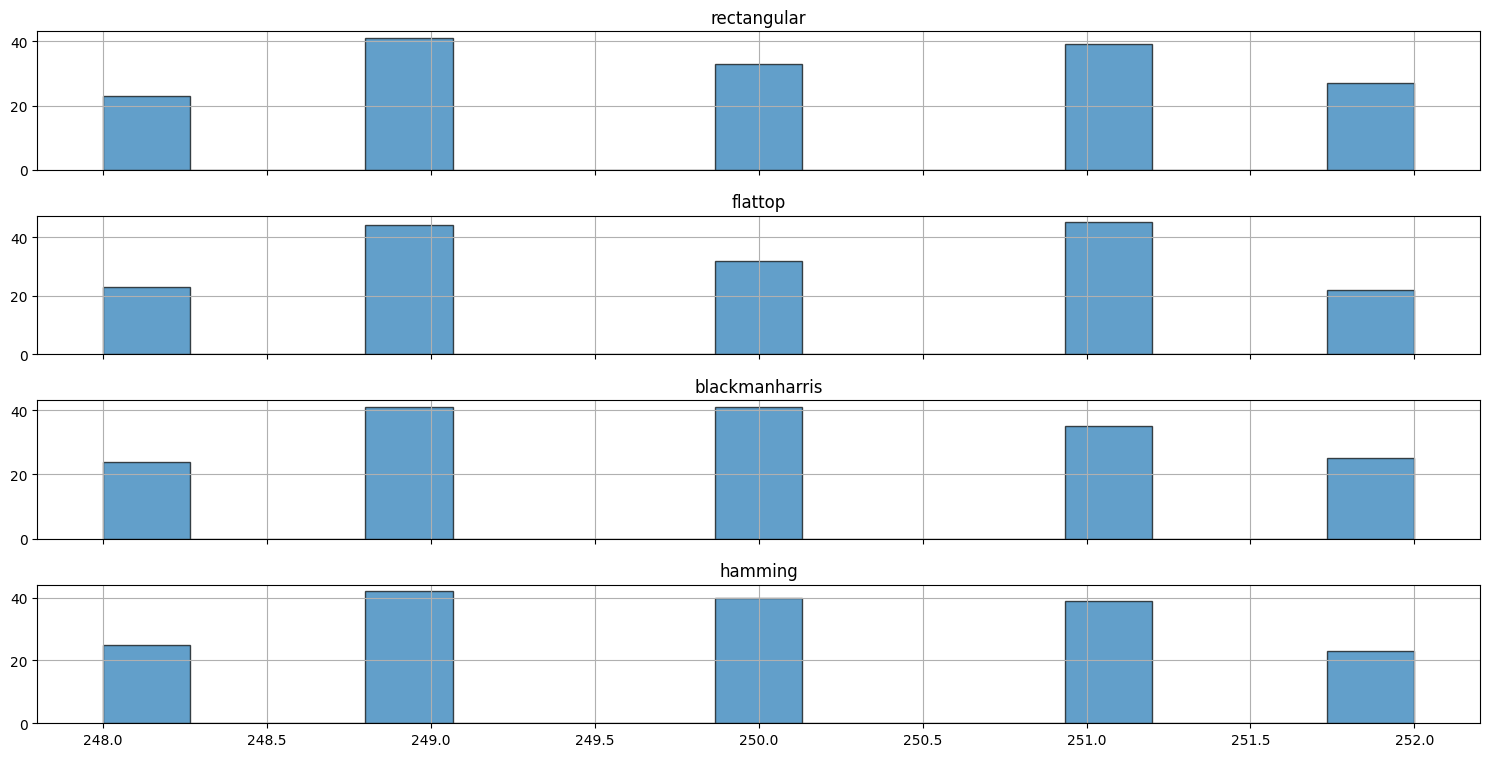

<Figure size 640x480 with 0 Axes>


Resultados para SNR = 3 dB
       Ventana  Bias_Amplitud  Var_Amplitud  Bias_Frecuencia  Var_Frecuencia
   rectangular      -0.882913      0.024092              0.0        0.000024
       flattop      -0.518837      0.003391              0.0        0.000024
blackmanharris      -0.626591      0.017912              0.0        0.000024
       hamming      -0.736364      0.030523              0.0        0.000024

Resultados para SNR = 10 dB
       Ventana  Bias_Amplitud  Var_Amplitud  Bias_Frecuencia  Var_Frecuencia
   rectangular      -0.897492      0.026558              0.0        0.000028
       flattop      -0.526144      0.002722              0.0        0.000026
blackmanharris      -0.691411      0.017403              0.0        0.000026
       hamming      -0.832417      0.031938              0.0        0.000026


In [2]:
import numpy as np
import scipy.signal as sc
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# Parámetros generales
N = 1000
fs = 1000
df = fs / N
R = 200                                 # realizaciones
frecuencia_central = N//4               # Medio de ancho de banda
a0 = 2                                  # amplitud 

SNRs = [3, 10]                          # dB

ventanas = {
    "rectangular": np.ones(N),
    "flattop": sc.windows.flattop(N),
    "blackmanharris": sc.windows.blackmanharris(N),
    "hamming": sc.windows.hamming(N)  
}

# Vector de tiempo
tt_vector = np.arange(N)/fs

resultados = []

for SNR_dB in SNRs:
    
    # Calculo de potencia del ruido
    P_signal = a0**2 / 2
    SNR_linear = 10**(SNR_dB/10)
    pot_ruido = P_signal / SNR_linear
    
    ff_vector = np.random.uniform(-2, 2, R)         # Vector fr

    # Matrices de senos
    tt_columnas = tt_vector.reshape((-1,1))
    ff_filas = ff_vector.reshape((1,-1))
    TT_sen = np.tile(tt_columnas, (1, R))
    FF_sen = np.tile(ff_filas, (N, 1))
    
    # Ruido
    ruido = np.random.normal(loc=0, scale=np.sqrt(pot_ruido), size=(N,R))
    
    # Señales
    xx_sen = a0 * np.sin(2*np.pi*(frecuencia_central + FF_sen)*df*TT_sen)
    xx_sen_ruido = xx_sen + ruido
    
    # Figuras
    fig_a, axes_a = plt.subplots(len(ventanas), 1, figsize=(15, 2*len(ventanas)), sharex=True)
    fig_f, axes_f = plt.subplots(len(ventanas), 1, figsize=(15, 2*len(ventanas)), sharex=True)

    # Ventaneo
    for  i,(win_name, ventana) in enumerate( ventanas.items()):
        
        U = np.sum(ventana)/N                          # Corrección de ganancia de la ventana
        xx_vent = xx_sen_ruido * ventana.reshape(-1,1)
        
        # FFT normalizada
        XX_sen = np.fft.fft(xx_vent, n=N, axis=0)/(N*U)
        freqs = np.fft.fftfreq(N, d=1/fs)
        
        # Estimadores
        a1_est = np.abs(XX_sen[frecuencia_central,:])      #Amplitud
        
        idx_max = np.argmax(np.abs(XX_sen), axis=0)
        Omega1_est = freqs[idx_max]                       
        
        # Filtrar frecuencias fuera del rango [0, fs/2]
        Omega1_est = Omega1_est[(Omega1_est >= 0) & (Omega1_est <= N//2)]  # Frecuencia
        
        # Estadísticos normalizados
        bias_a1 = (np.median(a1_est) - a0) / a0
        var_a1 = (np.var(a1_est, ddof=1)) / (a0**2)
        
        bias_Omega1 = (np.median(Omega1_est) - frecuencia_central) / frecuencia_central
        var_Omega1 = (np.var(Omega1_est, ddof=1)) / (frecuencia_central**2)
        
        resultados.append({
            "SNR_dB": SNR_dB,  
            "Ventana": win_name,
            "Bias_Amplitud": bias_a1,
            "Var_Amplitud": var_a1,
            "Bias_Frecuencia": bias_Omega1,
            "Var_Frecuencia": var_Omega1
        })
        
        # Graficar histogramas
        axes_a[i].hist(a1_est, bins=15,  edgecolor='black', alpha=0.7)
        axes_a[i].set_title(f"{win_name}")
        axes_a[i].grid(True)
        
        axes_f[i].hist(Omega1_est, bins=15,edgecolor='black', alpha=0.7)
        axes_f[i].set_title(f"{win_name}")
        axes_f[i].grid(True)
    
    axes_a[-1].set_xlabel("Amplitud estimada")
    fig_a.suptitle(f"Histogramas de Amplitud y Frecuencia con - SNR {SNR_dB} dB", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()
    
    axes_f[-1].set_xlabel("Frecuencia estimada [Hz]")
    fig_f.suptitle(f"Histogramas de Frecuencia - SNR {SNR_dB} dB", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

df = pd.DataFrame(resultados, columns=[
    "SNR_dB", "Ventana", "Bias_Amplitud", "Var_Amplitud",
    "Bias_Frecuencia", "Var_Frecuencia"
])

# Imprimir resultados por cada SNR 
for snr in df["SNR_dB"].unique():
    print(f"\nResultados para SNR = {snr} dB")
    print(df[df["SNR_dB"] == snr].drop(columns=["SNR_dB"]).to_string(index=False))

In [3]:
tablas_amp = {}
tablas_freq = {}

for snr in df["SNR_dB"].unique():
    df_snr = df[df["SNR_dB"] == snr]

    # Guardamos en variables
    tablas_amp[snr] = df_snr[["Ventana", "Bias_Amplitud", "Var_Amplitud"]].set_index("Ventana")
    tablas_freq[snr] = df_snr[["Ventana", "Bias_Frecuencia", "Var_Frecuencia"]].set_index("Ventana")

## Conclusiones


Viendo el histograma del estimador de amplitud y los resultados de sus estadisticos para SNR = 3dB (tablas_amp [3] ), podemos concluir que este metodo resulta en un estimador sesgado. También vemos, con gran diferencia, que la ventana flattop produce los mejores resultados en terminos de varianza con respecto a las otras ventanas. También su sesgo es el menor, pero la diferencia no es tan significativa.

In [8]:
display(tablas_amp[3])

,Bias_Amplitud,Var_Amplitud
Ventana,,
rectangular,-0.882913,0.024092
flattop,-0.518837,0.003391
blackmanharris,-0.626591,0.017912
hamming,-0.736364,0.030523


Al analizar los resultados para SNR = 10 dB (tablas_amp[10]), se observa que los estimadores no muestran una mejora significativa, a pesar de que se esperaría un desempeño más preciso al aumentar la relación señal-ruido. Vemos que el sesgo se encuentra invariante o peor de acuerdo con los resultados con SNR = 3dB, mientras que la varianza tiene una muy leve mejora en todas las ventanas. Por lo que, podemos concluir que para estos estimadores de amplitud un SNR = 3dB es suficiente.

In [5]:
display(tablas_amp[10])

,Bias_Amplitud,Var_Amplitud
Ventana,,
rectangular,-0.897492,0.026558
flattop,-0.526144,0.002722
blackmanharris,-0.691411,0.017403
hamming,-0.832417,0.031938


En resumen, podemos decir que, si bien mejora los estimadores al mejorar la relación señal- ruido, no parece tener tanta importantancia como elegir la ventana correcta. En este caso, para la estimación de amplitud la ventana "ganadora" es sin duda la flattop. Esto resulta coherente, ya que la ventana flattop fue específicamente diseñada para lograr estimaciones de amplitud precisas. Su lóbulo principal presenta una cima plana (de allí su nombre), lo que hace que el valor máximo del bin se mantenga prácticamente constante aun cuando la frecuencia de la señal no coincida exactamente con el centro de un bin. De este modo se reduce la pérdida por desparramo espectral, y en consecuencia disminuye el sesgo del estimador de amplitud. Aunque en principio podría pensarse que un lóbulo principal más ancho incrementaría la varianza, en condiciones de buena relación señal-ruido este efecto no se manifiesta.

En cuanto al estimador de frecuencia con SNR de 3db (tablas_freq[3]) y 10 dB (tablas_freq[10]) notamos resultados muy parecidos.

In [6]:
display(tablas_freq[3])

,Bias_Frecuencia,Var_Frecuencia
Ventana,,
rectangular,0.0,0.000024
flattop,0.0,0.000024
blackmanharris,0.0,0.000024
hamming,0.0,0.000024


In [7]:
display(tablas_freq[10])

,Bias_Frecuencia,Var_Frecuencia
Ventana,,
rectangular,0.0,0.000028
flattop,0.0,0.000026
blackmanharris,0.0,0.000026
hamming,0.0,0.000026


Por el contrario al estimador de amplitud, el estimador de frecuencia resultó insesgado (bias = 0 en todos los casos) y con una varianza muy baja y estable, prácticamente independiente de la ventana o del nivel de SNR. Esto indica que este método de estimación de frecuencia es robusto y no se ve afectado de manera significativa por la selección de la ventana, para esta aplicación.

En términos generales, los resultados obtenidos permiten distinguir con claridad el comportamiento diferencial de los estimadores de amplitud y de frecuencia. Por un lado, el estimador de amplitud se mostró sistemáticamente sesgado, con un bias prácticamente invariante al mejorar la relación señal-ruido. Además, la varianza de la estimación depende de manera marcada de la ventana utilizada: mientras que ventanas como rectangular o hamming presentan un sesgo elevado y una varianza considerable, la ventana flattop demostró un desempeño claramente superior, reduciendo significativamente la varianza y, en menor medida, el sesgo. 

Por otro lado, en la estimación de frecuencia se observa un comportamiento mucho más robusto: el estimador resulta insesgado en todos los casos analizados y alcanza varianzas muy bajas, con diferencias mínimas entre ventanas y sin mejoras sustanciales al incrementar el SNR de 3 dB a 10 dB. Esto sugiere que, a diferencia de la estimación de amplitud, la elección de la ventana y el aumento moderado del SNR no tienen un impacto significativo en la calidad de la estimación de frecuencia.

En conjunto, estos resultados permiten concluir que la selección de la ventana es un factor crítico para obtener estimaciones de amplitud confiables, mientras que la estimación de frecuencia se mantiene precisa y estable independientemente de dichas elecciones.